<a href="https://colab.research.google.com/github/komos0509/project/blob/main/%EB%8C%80%EA%B5%AC%EB%8C%80%ED%95%99%EA%B5%90_%EB%B9%84%EA%B5%90%EA%B3%BC_%EA%B5%AC%ED%98%84%ED%8E%B8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CAM

CAM(Class Activation Map)은 설명 가능한 AI 기술 중 하나다. 이미지 내에서 어느 부분이 모델의 의사결정에 큰 영향을 미쳤는지 시각화하는 기술이다.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/study/pytorch

/content/gdrive/My Drive/study/pytorch


데이터 및 모델 생성

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [ ]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform) # 96 x 96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

# 10 classes : 'airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'

Files already downloaded and verified


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

모델 학습

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
for epoch in range(20):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  cost = running_loss / len(trainloader)
  print('[%d] loss : %.3f' % (epoch+1, cost))

torch.save(model.state_dict(), './stl10_resnet18.pth')

print('Finished Training')

[1] loss : 0.542
[2] loss : 0.093
[3] loss : 0.035
[4] loss : 0.049
[5] loss : 0.125
[6] loss : 0.113
[7] loss : 0.059
[8] loss : 0.061
[9] loss : 0.083
[10] loss : 0.064
[11] loss : 0.052
[12] loss : 0.051
[13] loss : 0.062
[14] loss : 0.083
[15] loss : 0.063
[16] loss : 0.052
[17] loss : 0.064
[18] loss : 0.063
[19] loss : 0.060
[20] loss : 0.060
Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  model.eval()
  for data in trainloader:
    images, lables = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

Accuracy of the network on the train images: 9 %


CAM 모델 구축

In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  
  return hook

In [ ]:
def cam(model, trainset, img_sample, img_size):
  model.eval()
  with torch.no_grad():

    model.layer4[1].bn2.register_forward_hook(get_activation('final')) 
    data, label = trainset[img_sample]
    data.unsqueeze_(0)
    _ = model(data.to(device))
    act = activation['final'].squeeze()
    w = model.fc.weight # 가중치

    for idx in range(act.size(0)):
      if idx == 0:
        tmp = act[idx] * w[label][idx]
      else:
        tem += act[idx] * w[label][idx]

    normalized_cam = tmp.cpu().numpy()
    normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
    cam_img = cv2.resize(np.uint8(normalized_cam * 256), dsize = (img_size, img_size))
    original_img = np.unit8((data[0][0] / 2 + 0.5) * 255)

In [ ]:
def plot_cam(model, trainset, img_size, start):
  end = start + 20
  fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
  fig.subplots_adjust(hspace=.01, wspace=.01)
  axs = axs.ravel()

  for i in range(start, end):
    cam_img, original_img = cam(model, trainset, i, img_size)

    axs[i - start].imshow(original_img, cmap='gray')
    axs[i - start].imshow(cam_img, cmap='jet', alpha=.5)
    axs[i - start].axis('off')

  plt.show()
  fig.savefig('cam.png')

UnboundLocalError: ignored

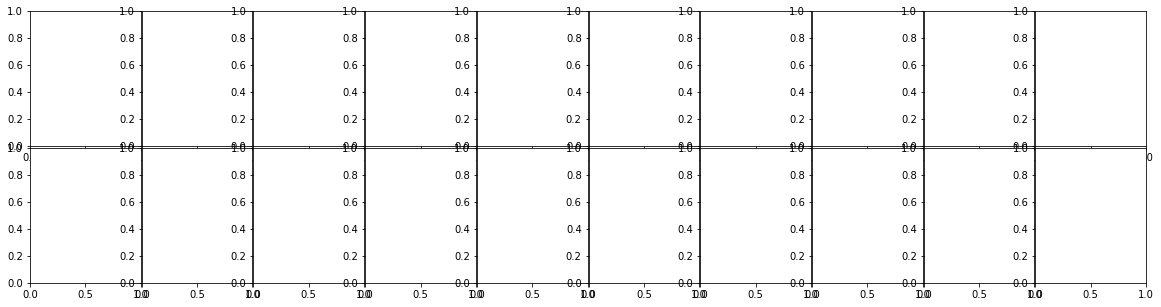

In [ ]:
plot_cam(model, trainset, 128, 10)

결과 시각화

t-SNE(t-distributed Stochastic Neighbor Embedding)
실험이 완료되면 결과를 시각화 하는 것이 매우 중요하다. 하지만 이미지나 추출 된 피쳐들은 차원이 높기 때문에 각 피쳐들이 어떤 분포를 가지고 있는지 표현하기 어렵다. 다시 말해서, 우리가 시각적으로 표현할 수 있는 차원은 3차원이기 때문에 고차원의 벡터들을 3차원 이하의 저차원으로 바꿔야만 한다. 따라서 이를 위해 자주 쓰이는 방법 중 하나인 t-SNE를 구현해 보자.

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd/content/gdrive/My Drive/study/pytorch

/content/gdrive/My Drive/study/pytorch


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(f'{device} is available')

cuda:0 is available


데이터 불러오기

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)


Files already downloaded and verified


모델 불러오기

In [ ]:
class Identity(nn.Module): # f(x) = x
  def __init__(self):
    super(Identity, self).__init__()

  def forward(self, x):
    return x

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 추출한다. 512개
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load('./cifar10_resnet18.pth'))
model.fc = Identity() # 512개를 입력받아 512개 그대로 출력

t-SNE

In [ ]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    features = model(images) # 512차원

    deep_features += features.cpu().detach().numpy().tolist()
    actual += labels.cpu().detach().numpy().tolist() # 실제값

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


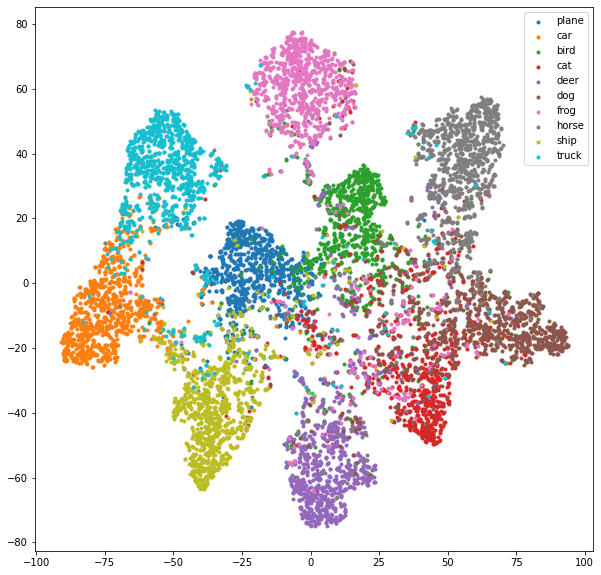

In [ ]:
 plt.figure(figsize=(10, 10))
 cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 for i, label in zip(range(10), cifar):
   idx = np.where(actual == i)
   plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()
plt.savefig('./cifar10_t-SNE.png')
plt.close()

데이터 불균형

데이터 불균형이란 데이터 세트 내의 클래스의 분포가 불균형한 것을 의미한다. 데이터 불균형은 특정 클래스의 과적합 되는 현상을 유발할 수 있기 때문에 반드시 해결해야 하는 문제이다.

(직접적 방법 3 + 간접적 방법 1)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd/content/gdrive/My Drive/study/pytorch

/content/gdrive/My Drive/study/pytorch


Weighted Random Sampling 

(전체 데이터가 불균형 해도 bacth 데이터를 균형있게 뽑아서 사용한다.)


In [ ]:
# 각 클래스의 비율을 정하여 뽑힐 확률에 대한 가중치를 산정한다. (가중치 곱하기)
import torch
from torch.utils.data import DataLoader
import torchvision
import numpy as np

def make_weighted_for_balanced_classes(img, nclasses):
  lable = []
  for i in range(len(img)):
    labels.appen(img[i][1])

  label_array = np.array(labels)
  total = len(labels)

  count_list = []
  for cls in range(nclasses):
    count = len(np.where(label_array == cls)[0])
    count_list.append(total/count)

  weights = []
  for label in label_array:
    weights.append(count_list[label])

  return weights

In [ ]:
trainset = torchvision.datasets.ImageFolder(root='./class', transform=tranf) # 데이터 세트 불러오기

weights = make_weighted_for_balanced_classes(trainset.imgs, len(trainset.classes)) # 가중치 계산
weights = torch.DoubleTensor(weights) # 텐서 변환
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) # 샘플링 방법 정의

trainloader = DataLoader(trainset, batch_size=16, sampler=sampler) # 데이터 로더 정의

# 이렇게 중간 3줄로 Weighted Random Sampling을 이용한다.

Weighted Loss Function

각각의 클래스 마다 loss가 계산될 때 가중치를 곱해주는 방식

In [ ]:
import torch.nn as nn
import torch

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
num_ins = [40, 45, 30, 62, 70, 153, 395, 46, 75, 194]
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Data Augmentation

over fitting에서도 쓰인다. 이미지를 늘려주는 방법 (적은 데이터가 없던 데이터를 만들어 용량을 늘리는 방법)

In [ ]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose(
    [tr.ToPILImage(), tr.RandomCrop(60), tr.ColorJitter(brightness=0.1, saturation=0.1, hue=0.1),
     tr.RandomHorizontalFlip(),
     tr.RandomRotation(10, resample=PIL.Image.BILINEAR),
     tr.ToTensor()
     ])


Confusion Matrix

어떤 클래스가 더 많이 맞았는지 보고 가중치를 줄 수 있다.

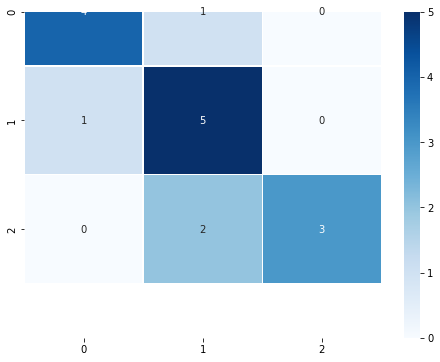

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
prediction = [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 2, 2, 1, 1]
c_mat = confusion_matrix(actual, prediction) # 실제 라벨, 예측값
plt.figure(figsize=(8, 6))
sns.heatmap(c_mat, annot=True, fmt='d', cmap='Blues', linewidths=.5)
b, t = plt.ylim()
b += 0.5
t += 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix.png')
plt.show()

과적합 

과적합은 학습 데이터에 치중하여 모델이 학습하는 현상으로 새로운 데이터에 대해서 대응을 못하는 문제다. 따라서 딥러닝에서 가장 쉽게 접할 수 있는 유형이지만 개선하기 힘든 문제다.

Dropout & Batch Normalization

모델 자체에서 계산을 컨트롤 하여 과적합을 방지하는 기술

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self. feature_extraction = nn.Sequential(nn.Conv2d(3, 6, 5),
                                             nn.BatchNorm2d(6), # 주로 Conv2d 연산 다음에 넣는다., 채널 수를 넣어주면 된다.
                                             nn.ReLU(),
                                             nn.MaxPool2d(2, 2),
                                             nn.Conv2d(6, 16, 5),
                                             nn.BatchNorm2d(16),
                                             nn.ReLU(),
                                             nn.MaxPool2d(2, 2))
    
    self.classifier = nn.Sequential(nn.Linear(512, 120), # classifier가 깊을수록 과적합 하기 쉽다.
                                    nn.ReLU(),
                                    nn.Dropout(0.5), # feature에는 넣지 않는다.
                                    nn.Linear(120, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 10))
    
  def forward(self. x):
    x = self.feature_extraction(x)
    x = x.view(-1, 512)
    x = self.classifier(x)

    return x
  
net = CNN().to(device)

L2 Regularization

loss 함수에다가 제약조건을 걸어주는 방법, 학습할 때 최적점에 가지 못하도록 boundary를 설정해 주는 것

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2) # lr : mu, weight_decay : lamda, weight_decay가 클수록 제약조건이 더 심해진다는 뜻

# L2 : w <- w - mu * (dL/dw + 2*lamda*w) = (1 - 2 * mu * lamda) * w - mu * dL/dw

Data Augmentation

Autoencoder, GAN같은 방법도 있다.

In [ ]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose([
                     tr.ToPILImage(), tr.RandomCrop(60), tr.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.1), # 이 자체가 Data Augmentation이다.
                     tr.RandomHorizontalFlip(),
                     tr.RandomRotation(10, resample=PIL.Image.BILINEAR),
                     tr.ToTensor()])

Label Smoothing

원 핫 벡터의 격차를 1대신에 0.8, 0대신에 0.2 이렇게 바꿔 과적합을 막는다.

In [ ]:
import troch.nn as nn

class LabelSmoothingLoss(nn.module):
  def __init__(self, classes, smoothing=0.0, dim=1):
    super(LabelSmoothingLoss, self),__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.cls = classes
    self.dim = dim

  def forward(self, pred, target):
    pred = pred.log_softmax(dim=self.dim) # Cross Entropy 부분의 log softmax 미리 계산하기
    with torch.no_grad():
      true_dist = torch.zeros_like(pred) # 예측값과 동일한 영텐서 만들기
      true_dist.fill_(self.smoothing / (self.cls - 1))
      true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # (1-alpha)y + alpha/(K-1)
    
    return torch.mean(torch.sum(-true_dist * pred, dim=self.dim)) # Cross Entropy Loss 계산


# 이 class를 복붙한다음에


In [ ]:
ls = LabelSmoothingLoss(10, smoothing=0.2) # Loss함수 지정하고

In [ ]:
for data in trainloader:
  ...
  ...
  loss = ls(pred, labels) # 이렇게 쓰기만 하면 된다. 

  ...
  ...